### 1. Import libraries and get data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

In [35]:
# Load the dataset
df = pd.read_csv("./BTC.csv")
df = df.reset_index()['Price']
df

0       25599.1
1       25591.3
2       25129.5
3       25929.4
4       25906.8
         ...   
2019    11667.1
2020    11623.9
2021    11246.2
2022    10912.7
2023    10861.5
Name: Price, Length: 2024, dtype: float64

In [36]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(df.shape)

(2024, 1)


### 2. Split the data into training, test and validate sets

In [37]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 1)
Test shape: (607, 1)
Validate shape: (203, 1)


In [38]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 1)
Test shape: (404, 1)
Validate shape: (204, 1)


In [39]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 1)
Test shape: (404, 1)
Validate shape: (406, 1)


In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (1113, 100)
y_train:  (1113,)
X_val:  (305, 100)
y_val:  (305,)
X_test:  (303, 100)
y_test (303,)


## 3. Perform GBT Model

### 3.1 Build and fit GBT Model with train data

In [42]:
gbt_model = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=42)
gbt_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=2000, random_state=42)

### 3.2 Evaluate on Validate data

In [43]:
def evaludate_gbt_model(x_data, y_data):
    predictions = gbt_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [44]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_gbt_model(x_val, y_val)

### 3.3 Evaluate on Test data

In [45]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_gbt_model(x_test, y_test)

### 3.4 Predict price for the next 30 days

In [46]:
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = gbt_model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = gbt_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", len(lst_output))

1 day output [0.05654546]
2 day output [0.05775139]
3 day output [0.06023594]
4 day output [0.0606655]
5 day output [0.0620942]
6 day output [0.06242657]
7 day output [0.06316215]
8 day output [0.06316215]
9 day output [0.06316215]
10 day output [0.0631079]
11 day output [0.0630824]
12 day output [0.0630824]
13 day output [0.0630824]
14 day output [0.0630824]
15 day output [0.06843046]
16 day output [0.06843046]
17 day output [0.06883181]
18 day output [0.06883181]
19 day output [0.06883181]
20 day output [0.06824707]
21 day output [0.06547248]
22 day output [0.06547248]
23 day output [0.06459096]
24 day output [0.06575074]
25 day output [0.0656055]
26 day output [0.06312767]
27 day output [0.06312767]
28 day output [0.06312767]
29 day output [0.06312767]
Output of predicted next days:  30


In [47]:
y_pred_test = y_pred_test.reshape(-1,1)
y_pred_val = y_pred_val.reshape(-1,1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

print("Test data prediction:", y_pred_test.shape)
print("Val data prediction:", y_pred_val.shape)

Test data prediction: (303, 1)
Val data prediction: (305, 1)


In [48]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

               MSE       MAE      MAPE      RMSE
Validate  0.000917  0.018356  0.166999  0.030278
Test      0.000933  0.026045  2.110476  0.030543


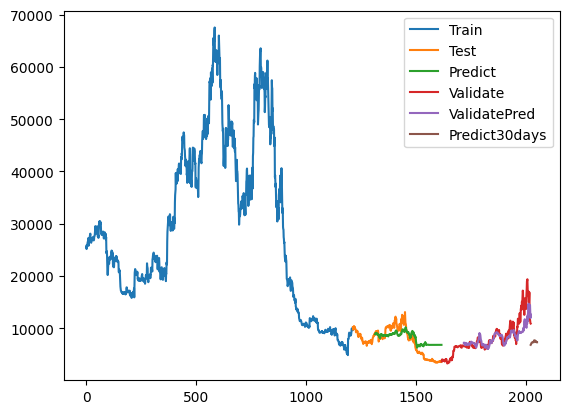

In [49]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()